#Smartphone-Based Democratization of Jump Height Estimate
## Brief overview
The multiple linear regression coefficient listed below were computed by combining anthropometric and time-frequency parameters of a dataset composed by 17 subjects performing 3 countermovement- and 3 squat-jumps onto a forceplatform. Apart from the latter instrument, smartphone data were also collected through the app Phyphox [[1]](#phyphox).

<img src="https://media.giphy.com/media/ScJgZ7lXoq4DponLRK/giphy.gif" align = "center">

Jumps were executed bringing the smartphone at the chest, with the elbow at waist height. Four skinfold lengths were measured, namely biceps, triceps, sub-scapular, and superior-anterior iliac crest ($B$, $T$, $S$, and $I$, respectively). Time-frequency features were extracted either directly from the accleration trace (negative and positive acceleration peak - $NP$ and $PP$ - and their ratio - $R_{PN}$), or through Variational Mode Decomposition [[2]](#VMD) in the form of central frequencies ($f_1$, $f_2$, and $f_3$). 

Once all the features were readily available, the best subset regression method was used to select the best subset of features reducing the error from the *gold standard* estimates. Once obtained, each model was validated through a 10-fold cross validation. 

## The regression models

Here we have the coefficients of the Multiple Linear Regression obtained for the ISB2021 abstract:

|                     | Constant ($b_0$)   | $\hat{h}$ ($b_1$) | B ($b_2$) | T ($b_3$) | S ($b_4$) | I ($b_5$) | $f_3$ ($b_6$) | R<sub>PN</sub> ($b_7$) |
| ------------------- | ------------------ | ----------------- | --------- | --------- | --------- | --------- | ------------- | ---------------------- |
| MLR<sub>CMJ</sub>   | .385               | .101              | -.004     | -.005     | -.004     |     -     | -.08          | -                      |
| MLR<sub>SJ</sub>    | .161               | .31               | -         | -         | -.009     | .005      | -             | .034                   |

were $\hat{h}$ is the jump height estimated through smartphone measures. 

In [1]:
## -- Load packages -- ##
import numpy as np                     # Array package
import pandas as pd                    # Data-Frame package
import math                            # "Basic Advanced" maths operations
import matplotlib.pyplot as plt        # Advanced plot tool
from scipy import integrate, signal    # Signal processing tool

## Quaternions
First of all, we need to know what a quaternion is, what it represents and how we represent it. A quaternion, denoted as $\mathbf{q}$, is a formal mathematical object, serving as an extension of the complex numbers. Besides mathematical formalism and history (even though <a href = "https://en.wikipedia.org/wiki/William_Rowan_Hamilton#Quaternions">very interesting!</a>), such a representation is often used to get the orientation of a given body into three-dimensional space. A quaternion $\mathbf{q}$ is expressed as:

\begin{equation*} \mathbf{q} = w + x\mathbf{i} + y\mathbf{j} + z\mathbf{k} \end{equation*}

where $w$ is the scalar component, while $x\mathbf{i}$, $y\mathbf{j}$, and $z\mathbf{k}$ build up the vectorial one. Now, we need to define two quaternion operations, namely the quaternion *conjugate* and the quaternion *product*. 

### Quaternion conjugate <a id='q_conj'></a>
Let consider a quaternion $\mathbf{q} = \begin{bmatrix}w & x\mathbf{i} & y\mathbf{j} & z\mathbf{k} \end{bmatrix}$. Its conjugate, $\mathbf{q}^*$ is defined as:

\begin{equation*} \mathbf{q}^* = \begin{bmatrix}w & -x\mathbf{i} & -y\mathbf{j} & -z\mathbf{k} \end{bmatrix} \end{equation*}

### Quaternion product
Now, let consider two quaternions, $\mathbf{q}_1$ and  $\mathbf{q}_2$. The quaternion product ($x \otimes y$) is defined according to the *Hamilton product* as:
    
\begin{align*} x \otimes y =  & w_1 w_2 - x_1 x_2 - y_1 y_2 - z_1 z_2\ + \\
                     + & (w_1 x_2 + x_1 w_2 + y_1 z_2 - z_1 y_2) \mathbf{i}\ + \\ 
                     + & (w_1 y_2 - x_1 z_2 + y_1 w_2 + z_1 x_2) \mathbf{j}\ + \\
                     + & (w_1 z_2 + x_1 y_2 - y_1 x_2 + z_1 w_2) \mathbf{k}  \end{align*}
    
It must be noticed that the quaternion product is **not** commutative.

In [2]:
# Quaternion Conjugate
def quaternConj(q):
    w, x, y, z = q
    return np.array([w, -x, -y, -z], dtype = np.float64)

# Quaternion Product
def quaternProd(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([w1*w2 - x1*x2 - y1*y2 - z1*z2,
                     w1*x2 + x1*w2 + y1*z2 - z1*y2,
                     w1*y2 - x1*z2 + y1*w2 + z1*x2,
                     w1*z2 + x1*y2 - y1*x2 + z1*w2])

## Other representations

<p align = "center"><img width="300" src="./misc/rpy.svg"></p>

The advantage of quaternions are multiple. First of all, they are computationally cheap, indeed they are often used as the main representation in *on-board* IMUs. Secondly, they avoid singularity issues (e.g. <a href = "https://en.wikipedia.org/wiki/Gimbal_lock">gimbal lock</a>). However, they are not used in many human-related fields like biomechanics, since they do not allow a *user-friendly* representation of the rotations a body is performing. For this reason, other representations must  be used, often being *Euler angles*.

Fortunately, it is possible to switch from one representation to another relatively easily, as we can see in the following paragraphs. 
### Quaternions to Euler angles

Let consider a quaternion $\mathbf{q} = w + x\mathbf{i} + y\mathbf{j} + z\mathbf{k}$. It is possible to convert it into *Euler angles* according to the following relationship: 

\begin{align*} \begin{bmatrix}
\phi \\ \theta \\ \psi
\end{bmatrix} =
\begin{bmatrix}
\mbox{atan2}  [ 2(w x + y z),1 - 2(x^2 + y^2) ] \\
\mbox{asin} [ 2(w y - z x) ] \\
\mbox{atan2}  [ 2(w z + x y),1 - 2(y^2 + z^2) ]
\end{bmatrix} \end{align*}

where $\phi$, $\theta$, and $\psi$ are referred to as the *roll*, *pitch*, and *yaw* angle, respectively. Notice that this is a computer implementation of the conversion, hence the function ```atan2(x, y)``` is used. The reason beneath this choice is that the regular ```atan(x)``` function cannot distinguish the quadrant the arc belongs to (1<sup>st</sup> vs. 3<sup>rd</sup> or 2<sup>nd</sup> vs. 4<sup>th</sup>). The double argument helps the interpreter to understand it, avoiding ambiguities. You can find more information <a href = "https://en.wikipedia.org/wiki/Atan2#History_and_motivation">here</a>.

## Euler angles to Quaternions
Let consider three Euler angles in the form of roll ($\phi$), pitch ($\theta$), and yaw ($\psi$). The quaternion $\mathbf{q} = w + x\mathbf{i} + y\mathbf{j} + z\mathbf{k}$ can be computed as:

\begin{align*}w & = \cos \bigg( \frac{\phi}{2} \bigg) \cdot  \cos \bigg( \frac{\theta}{2} \bigg) \cdot \cos \bigg( \frac{\psi}{2} \bigg) + \sin \bigg( \frac{\phi}{2} \bigg) \cdot \sin \bigg(\frac{\theta}{2} \bigg) \cdot \sin \bigg( \frac{\psi}{2} \bigg)\\
x & = \sin \bigg( \frac{\phi}{2} \bigg) \cdot \cos \bigg( \frac{\theta}{2} \bigg) \cdot \cos \bigg( \frac{\psi}{2} \bigg) - \cos \bigg( \bigg( \frac{\phi}{2} \bigg) \cdot \sin \bigg( \frac{\theta}{2} \bigg) \cdot \sin \bigg( \frac{\psi}{2} \bigg) \\
y & = \cos \bigg( \frac{\phi}{2} \bigg) \cdot \sin \bigg( \frac{\theta}{2} \bigg) \cdot \cos \bigg( \frac{\psi}{2} \bigg) + \sin \bigg( \frac{\phi}{2} \bigg) \cdot \cos \bigg( \frac{\theta}{2} \bigg) \cdot \sin \bigg( \frac{\psi}{2} \bigg)\\
z & = \cos \bigg( \frac{\phi}{2} \bigg) \cdot \cos \bigg( \frac{\theta}{2} \bigg) \cdot \sin \bigg( \frac{\psi}{2} \bigg) - \sin \bigg( \frac{\phi}{2} \bigg) \cdot \sin \bigg( \frac{\theta}{2} \bigg) \cdot \cos \bigg( \frac{\psi}{2} \bigg)
\end{align*}

In [3]:
# Quaternions to Euler Angles
def quatern2eul(q):
        N = q.shape[0]
        roll_x = np.zeros(N)
        pitch_y = np.zeros(N)
        yaw_z = np.zeros(N)
        
        for k in range(0, N):
            w, x, y, z = q[k,:]
            t0 = +2.0 * (w * x + y * z)
            t1 = +1.0 - 2.0 * (x * x + y * y)
            roll_x[k] = math.atan2(t0, t1)

            t2 = +2.0 * (w * y - z * x)
            t2 = +1.0 if t2 > +1.0 else t2
            t2 = -1.0 if t2 < -1.0 else t2
            pitch_y[k] = math.asin(t2)

            t3 = +2.0 * (w * z + x * y)
            t4 = +1.0 - 2.0 * (y * y + z * z)
            yaw_z[k] = math.atan2(t3, t4)
         
        return roll_x, pitch_y, yaw_z # [rad]

# Euler Angles to Quaternions
def eul2quatern(roll_x, pitch_y, yaw_z):
    N = roll_x.shape[0]
    q = np.zeros((N,4))
    
    for k in range(0,N):
        cy, sy = np.cos(yaw_z[k] * .5), np.sin(yaw_z[k] * .5)
        cp, sp = np.cos(pitch_y[k] * .5), np.sin(pitch_y[k] * .5)
        cr, sr = np.cos(roll_x[k] * .5), np.sin(roll_x[k] * .5)
        
        w = cr * cp * cy + sr * sp * sy
        x = sr * cp * cy - cr * sp * sy
        y = cr * sp * cy + sr * cp * sy
        z = cr * cp * sy - sr * sp * cy
        q[k,:] = w, x, y, z
    
    return q

# Complementary filter <a id='complementary_filter_theory'></a>

At this point, we need to estimate the smartphone-IMU orientation in the three-dimensional space. 

The idea behind a (very general!) complementary filter is to exploit the *best feature* of the accelerometer to correct for gyroscope inaccuracies and *viceversa*. We need to keep in mind that:

* The accelerometer has a high-frequency noise, but its measures remain stable with time;
* The gyroscope has a low-frequency noise, referred to as *drift*, but its measures are smoother over a short timespan. 

Hence, a complementary filter applies:

* A low-pass filter onto the accelerometer measures, *smoothing* the original signal;
* A high-pass filter onto the gyroscope measures, removing the drift-trending.

To give a brief overview, let consider only one axis. The angle between the MIMU axis and the respective global reference frame axis is $\theta$. The general angle at time sample $k$ is computed as: 

\begin{equation*} \theta[k] =  (1-\beta) \cdot (\theta[k-1] + \omega[k] \cdot dk) + \beta \cdot \alpha[k] \end{equation*}

where: $\omega[k]$ is the angular velocity at sample $k$; $\alpha[k]$ is the angle computed with ```atan2(x, y)``` at sample $k$; $\theta[k-1]$ is the angle computed at the previous time sample; $dk$ is the sampling period; $\beta \in \begin{bmatrix} 0, 1 \end{bmatrix}$ is the filter coefficient, a.k.a. its *tuning parameter*. 

The first term of the previous equation is a sort of high-pass filter, whereas the secon term is a low-pass one. The choice of $\beta$ is critical. According to the equation above, its general purpose is to make us trust more one instruments above the other one. The bigger $\beta$, the more we trust the gyroscope; on the contrary, the smaller $\beta$, the more we trust the accelerometer.

Notice that such kind of filter is designed for IMU (accelerometer plus gyroscope). Thus, no proper correction for the Yaw angle can be applied. To do so, a magnetometer is required. However, for the purpose of this study, the Yaw angle was not taken into account. 

In [4]:
# --- Simple Complementary Filter 
def my_cf(acc_data, gyr_data, fs, beta):
    N = acc_data.shape[0]
    roll_x, pitch_y, yaw_z, angle_x, angle_y, angle_z = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
    dk = 1/fs
    
    for k in range(1,N):

        alpha_x = np.arctan2(acc_data[k,1], acc_data[k,2])
        alpha_y = np.arctan2(-acc_data[k,0],  np.sqrt( np.square(acc_data[k,1]) + np.square(acc_data[k,2]) ))

        angle_x[k] = 0.5 * ( gyr_data[k-1,0] + gyr_data[k,0] ) + angle_x[k-1]
        angle_y[k] = 0.5 * ( gyr_data[k-1,1] + gyr_data[k,1] ) + angle_y[k-1]
        angle_z[k] = 0.5 * ( gyr_data[k-1,2] + gyr_data[k,2] ) + angle_z[k-1]

        roll_x[k] = (1 - beta) * ( angle_x[k-1] + gyr_data[k,0] * dk ) + beta * alpha_x
        pitch_y[k] = (1 - beta) * ( angle_y[k-1] + gyr_data[k,1] * dk ) + beta * alpha_y
        yaw_z[k] = angle_z[k] 
        
    return roll_x*np.pi/180, pitch_y*np.pi/180, yaw_z*np.pi/180 # Angles in [rad]

# Aligning the vertical component to the world reference frame (WRF)

The idea is to remove correctly the gravity. To this aim, the technique proposed in [[3]](#rant), through which a *global* vertical acceleration is computed. 

In order to get the acceleration into the WRF, the following steps are required:

1. Compute the *acceleration quaternion*, that is a quaternion composed by null scalar component ($w = 0$) and the accelerometer measure as the vectorial component:

    \begin{equation}\mathbf{a}^q = \begin{bmatrix} 0 & a_x \mathbf{i} & a_y \mathbf{j} & a_z \mathbf{k} \end{bmatrix}\end{equation}
    
2. Get the orientation quaternion $\mathbf{q}$ of the entire trial by using the [complementary filter](#complementary_filter_theory) and compute its [conjugate](#q_conj) $\mathbf{q}*$

3. Apply, for each time sample, the following relationship: 
    
    \begin{equation} a^{glob} = \mathbf{q} \otimes \mathbf{a}^q \otimes \mathbf{q}* \end{equation}
    
Gravity can now be removed from the vertical component of the acceleration, and we can store it for further computations.

In [5]:
def align_to_WRF(q, acc):
    N = acc.shape[0]
    a_q, q_star, q_glob = np.zeros((N,4)), np.zeros((N,4)), np.zeros((N,4))
    a_q[:,1:] = acc

    for t in range(0,N):
        q_star[t] = quaternConj(q[t])
        q_temp = quaternProd(q[t], a_q[t])
        q_glob[t] = quaternProd(q_temp, q_star[t])

    return q_glob[:,2] - np.mean(q_glob[0:100,2])

# Compute jump height

<img src="./misc/vel.png" align = "center">

For this study, the take off velocity method was taken into account. The rationale beneath this choice is based upon biomechanical considerations. Many compute jump height through flight time and ballistic motion equation. This approach would have two main issues:

1. The jump, from take-off to end-of-flight, should be executed in a perfectly simmetrical way, which is never the case;
2. The correct timings are almost indistinguishable when not using force platforms. 

The take-off velocity method requires two boundaries: the *start bending* ($SB$) and the *take-off* ($TO$), the former being the first time sample where the vertical acceleration goes below zero (i.e. the beginning of the countermovement stage), the latter being the time sample where the measured vertical acceleration is $-9.81\ m/s^2$ (i.e. the last sample where the feet are in contact with the ground). 
If no countermovement occurs (as in Squat Jumps), $SB$ is considered to be the first sample where the acceleration rises after the static stage. 

The velocity trace is computed through numerical integration of the acceleration one, as:

\begin{equation} v(t) = \int_{SB}^{TO} a^{glob}(t) dt \end{equation}

Hence, the following equation applies for height calculation:

\begin{equation} h = \frac{v_{TO}^2}{2g} \end{equation}

where $v_{TO}$ is the velocity at take-off and $g = 9.81$ is the gravitational acceleration. Notice that the maximum velocity is reached prior the actual take-off.

In [6]:
# Take-Off Velocity method for h computation
def get_height(a_glob, sb, to, fs, plot):
    L = to - sb    # Length of the acceleration to be considered
    t = np.linspace(0, L/fs, num = L)    # Create the linspace time vector for the integration
    v = integrate.cumtrapz(a_glob[sb:to], t, initial=0)    # Perform the integration
    
    if plot == 1:
        fig = plt.figure(1)
        fig.dpi = 150
        plt.plot(t,v)
        plt.xlim([0,L/fs]), plt.title("Velocity from start bending to take-off"), plt.xlabel("Time (s)"), plt.ylabel("Velcity (m/s)")
    
    return( ( 0.5 * np.square(v[-1]) ) / g )

In [7]:
## -- Global Variables
fs = 128                   # Sampling Frequency [samples/s]
beta = .02                 # Complementary Filter Coefficient 
g = 9.81                   # Gravitational acceleration [m/s^2]
sb_sp, to_sp = 172, 267    # Start Bending and Take-Off time instant for the smartphone
sb_fp, to_fp = 161, 274    # Start Bending and Take-Off time instant for the forceplate

Height obtained for:
 Smartphone = 0.14 [m]
 Forceplate = 0.23 [m]


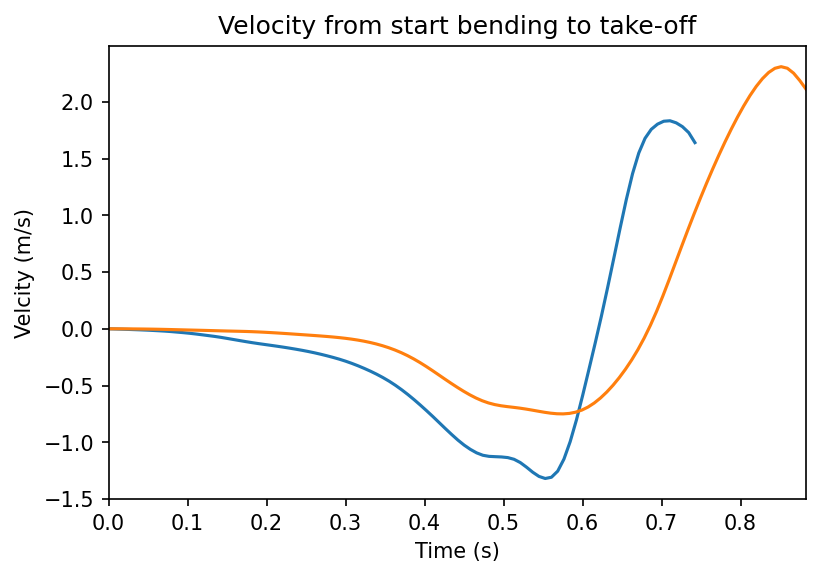

In [8]:
## -- Load the jump -- ##
x1 = pd.read_csv('./data/cmj_smartphone.csv')
x2 = pd.read_csv('./data/cmj_forceplate.csv')
a_fp = pd.DataFrame.to_numpy(x2['ay'])    # Convert forceplate acceleration into Numpy array

## -- Convert accelerometer and gyroscope into Numpy arrays
acc_data = pd.DataFrame.to_numpy(x1[['ax','ay','az']])
gyr_data = pd.DataFrame.to_numpy(x1[['gx','gy','gz']])

r,p,y = my_cf(acc_data, gyr_data, fs, beta)    # Compute trial orientation fusing accelerometer and gyroscope
q = eul2quatern(r,p,y)    # Convert angles into a quaternion
a_glob = align_to_WRF(q, acc_data)    # Align to WRF
np.savetxt("./data/a_glob.csv", a_glob, delimiter = ",")    # Store the aligned vertical acceleration

h_sp = round(get_height(a_glob, sb_sp, to_sp, fs, 1), 2)
h_fp = round(get_height(a_fp, sb_fp, to_fp, fs, 1), 2)
print("Height obtained for:\n " + "Smartphone = " + str(h_sp) + " [m]\n Forceplate = " + str(h_fp) + " [m]")

# Variational Mode Decomposition

The last step is to extract the three central frequencies through Variational Mode Decomposition [[2]](#VMD). Basically, such technique is able to subdivide a time series $x(t)$ in $K$ sub-signals referred to as *intrinsic mode functions* (IMF). Each IMF will be centered around a certain central frequency. The sum, sample by sample, of the $K$ sub-signals will give back the original time-series $x(t)$.

We decided to isolate $K = 3$ IMFs, each referring to *something*. The high- and mid-frequency IMFs ($f_1$ and $f_2$, respectively) were associated with noise, inertial effects, and wobbling masses; the low-frequency IMF ($f_3$) was associated with the jump.

You got the following central frequencies:
 f1 = 4.89 [Hz]
 f2 = 2.08 [Hz]
 f3 = 1.17 [Hz]


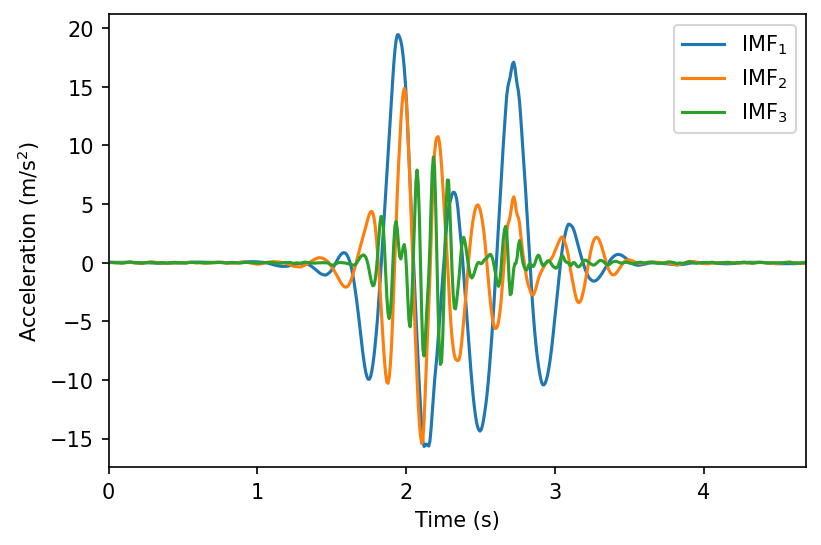

In [9]:
## --- Apply VMD --- ##
from vmdpy import VMD
## --- VMD Parameters --- ##
alpha = 100        # Mid Bandwidth Constrain  
tau = 0            # Noise-tolerance (no strict fidelity enforcement)  
K = 3              # 3 IMFs  
DC = 0             # DC part not imposed  
init = 0           # Initialize omegas uniformly  
tol = 1e-20        # Tolerance parameter

time = np.linspace(0, a_glob.shape[0]/fs, num = a_glob.shape[0])

## --- Run VMD on smartphone aligned acceleration trace --- ## 
u, u_hat, omega = VMD(a_glob, alpha, tau, K, DC, init, tol)  
IMFs = np.transpose(u)

fig = plt.figure(1)
fig.dpi = 150
plt.plot(time, IMFs)
plt.xlabel('Time (s)'), plt.ylabel('Acceleration (m/s$^2$)'), plt.xlim([time[0], time[-1]])
plt.legend(['IMF$_1$', 'IMF$_2$', 'IMF$_3$'])

f3, f2, f1 = omega[-1] * ( fs / 2 )    # Convert the central-frequencies to their "actual value"
print("You got the following central frequencies:\n f1 = " + str(round(f1, 2)) + " [Hz]\n f2 = " + str(round(f2, 2)) + 
     " [Hz]\n f3 = " + str(round(f3, 2)) + " [Hz]")

In [10]:
## ---- Regression coefficients ---- ##
# Legend:
# b0 = constant; b1 = h_hat; b2 = biceps; b3 = triceps; b4 = scapula; b5 = f3
b0, b1, b2, b3, b4, b5, b6, b7  = .385, .101, -.004, -.005, -.004, 0, -.08, 0

## ---- Subject skinfolds (mm) ---- ##
B, T, S, I = 2.3, 7, 10, 9

h_mlr = round(b0 + b1 * h_sp + b2 * B + b3 * T + b4 * S + b5 * I + b6 * f3, 2)

print("Height obtained for:\n " + "Smartphone = " + str(h_sp) + " [m]\n Forceplate = " + str(h_fp) + 
      " [m]\n MLR = " + str(h_mlr) + " [m]\n")

print("Mean Absolute Errors:\n Smartphone = " + str(np.abs(h_fp - h_sp)) + " [m]\n MLR = " + 
      str(round(np.abs(h_fp - h_mlr), 2)) + " [m]")

Height obtained for:
 Smartphone = 0.14 [m]
 Forceplate = 0.23 [m]
 MLR = 0.22 [m]

Mean Absolute Errors:
 Smartphone = 0.09 [m]
 MLR = 0.01 [m]


# References
<a id='phyphox'>[1]</a> Staacks, Sebastian & Hütz, Simon & Heinke, Heidrun & Stampfer, Christoph. (2018). Advanced tools for smartphone-based experiments: Phyphox. Physics Education. 53. https://doi.org/10.1088/1361-6552/aac05e

<a id='VMD'>[2]</a> K. Dragomiretskiy and D. Zosso, "Variational Mode Decomposition," in IEEE Transactions on Signal Processing, vol. 62, no. 3, pp. 531-544, Feb.1, 2014, https://doi.org/10.1109/TSP.2013.2288675

<a id='rant'>[3]</a> Rantalainen, T, Finni, T, Walker, S. Jump height from inertial recordings: A tutorial for a sports scientist. Scand J Med Sci Sports. 2020; 30: 38– 45. https://doi.org/10.1111/sms.13546 

# Credits
All the material here presented is released with license **<a href = "https://creativecommons.org/licenses/by-nc/4.0/legalcode">CC BY-NC</a>**. You are free to:

- **Share** — copy and redistribute the material in any medium or format.
- **Adapt** — remix, transform, and build upon the material.

Under the following terms:
- **Attribution** — You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
- **NonCommercial** — You may not use the material for commercial purposes.

If you have any question, please contact me at <a href = "mailto:mascia.guido@gmail.com">mascia.guido@gmail.com</a>

<p align="center"><a href = "https://creativecommons.org/licenses/by-nc/4.0">
  <img width="100" height="35" src="./misc/by-nc.png" alt = "CC BY NC"> </a>
</p>